##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to generate musical notes using a simple recurrent neural network (RNN). You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial.

## Record Voice

In [1]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=10): # change here the duration of the recording
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b)) # remove this line if you want to save the audio without playing it
  with open('voice.wav','wb') as f:
    f.write(b)
  return audio

In [2]:
import sounddevice as sd
from scipy.io.wavfile import write

# Parameters
fs = 44100  # Sample rate
seconds = 10  # Duration of recording
filename = 'output.wav'  # Output filename

print("Recording...")
recording = sd.rec(int(seconds * fs), samplerate=fs, channels=2, dtype='int16')
sd.wait()  # Wait until recording is finished
print("Finished recording.")

write(filename, fs, recording)  # Save as WAV file

ModuleNotFoundError: No module named 'sounddevice'

In [3]:
record()

<IPython.core.display.Javascript object>

Modify the paths:
1) Where to save the midi file
2) The file to convert

In [4]:
!pip install basic-pitch
!basic-pitch /content/ voice.wav

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.5/373.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 8.4 MB/s eta 0:00:00
  Created wheel for mir-eval: filename=mir_eval-0.7-py3-none-any.whl size=100703 sha256=b638c74bcbd1a232bc0fc6a72ea870b71053e49f6d0f420f3fe958a807e0ddda
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=d25954a49e58528949bd76e9ff11ec9c267b89f8b038b00a5a87959c48d04fbf
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9e

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [5]:
!pip install fluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for fluidsynth: filename=fluidsynth-0.2-py3-none-any.whl size=4487 sha256=34e4e586273aaa0ff203c0a89b1a4f32c8d1d50796906024993deb4b981f5666
  Stored in directory: /root/.cache/pip/wheels/72/5a/bf/347b142f199fb1bea87f16f8970916226951bc359c947ba19b
Successfully built fluidsynth


In [6]:
!pip install --upgrade pyfluidsynth

In [7]:
!pip install pretty_midi

In [8]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import cv2
import dlib
import numpy as np
import time
import threading

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [9]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000


## Smile Detection

In [10]:
def is_smiling(landmarks):
    # Get the coordinates of the mouth landmarks
   # Points for the left and right of the mouth
    left_mouth = (landmarks.part(48).x, landmarks.part(48).y)
    right_mouth = (landmarks.part(54).x, landmarks.part(54).y)

    # Points for the top and bottom of the mouth
    top_mouth = (landmarks.part(51).x, landmarks.part(51).y)
    bottom_mouth = (landmarks.part(57).x, landmarks.part(57).y)

    # Calculate distances
    horizontal_dist = np.linalg.norm(np.array(left_mouth) - np.array(right_mouth))
    vertical_dist = np.linalg.norm(np.array(top_mouth) - np.array(bottom_mouth))

    # Aspect ratio
    aspect_ratio = vertical_dist / horizontal_dist

    # Threshold can be adjusted based on empirical data
    smile_threshold = 0.30

    return aspect_ratio < smile_threshold


In [12]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [21]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = output.eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
  #    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [14]:
# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # You need to download this file

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
face found


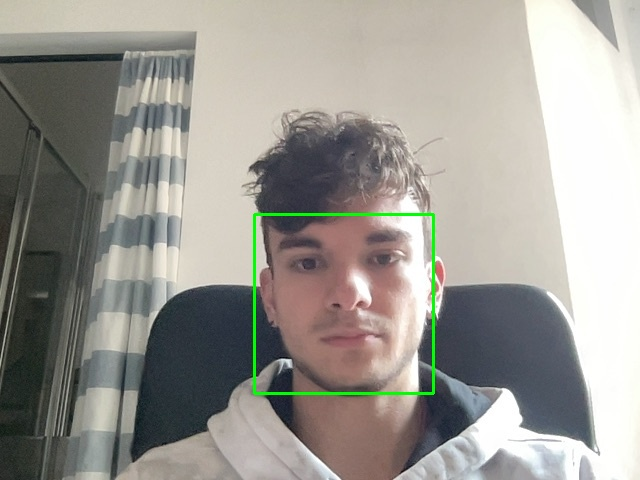

In [50]:
from IPython.display import display, Javascript, Image
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  photo = cv2.imread('photo.jpg')
  gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # You need to download this file

  faces = detector(gray)
  if len(faces) == 0:
    print("no face detected, please try again")

  else:
    for face in faces:
      print("face found")
      landmarks = predictor(gray, face)

    if is_smiling(landmarks):
      color = (0, 255, 0) # Green
    else:
      color = (0, 0, 255) # Red

    x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(photo, (x1, y1), (x2, y2), color, 2)

    cv2.imwrite(filename, photo)
    # Show the image which was just taken.
    display(Image(filename))
    label = 1 if is_smiling(landmarks) else -1
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## import kmeans model

In [29]:
import pickle

def analyze_midi(notes_sequence):

    # pm = pretty_midi.PrettyMIDI(midi_file)

    # get tempo changes
    # tempo_changes = notes_sequence.get_tempo_changes()
    # bpm = np.mean(tempo_changes)

    # get notes
    # notes = []
    # for instrument in notes_sequence.instruments:
    #     for note in instrument.notes:
    #         notes.append(note)

    # suppose the triples are (pitch, step, duration)
    # ANDREA CAMBIALO SE NECESSARIO

    # get notes steps
    # sorted_notes = sorted(notes_sequence, key=lambda note: note.start)
    # prev_start = sorted_notes[0].start
    steps = [note[1] for note in notes_sequence]
    # for note in sorted_notes:
    #     start = note.start
    #     steps.append(start - prev_start)
    #     prev_start = start
    avg_step = np.mean(steps)
    max_step = np.max(steps)
    std_step = np.std(steps)


    # get note durations
    # durations = [note.end - note.start for note in notes_sequence]
    durations = [note[2] for note in notes_sequence]
    # get average duration
    avg_duration = np.mean(durations)
    max_duration = np.max(durations)
    std_duration = np.std(durations)

    # get note pitches
    # pitches = [note.pitch for note in notes_sequence]
    pitches = [note[0] for note in notes_sequence]
    # get average pitch
    avg_pitch = np.mean(pitches)
    max_pitch = np.max(pitches)
    std_pitch = np.std(pitches)


    return {
        # 'bpm': bpm,
        'avg_step': avg_step,
        'max_step': max_step,
        'std_step': std_step,
        'avg_duration': avg_duration,
        'max_duration': max_duration,
        'std_duration': std_duration,
        'avg_pitch': avg_pitch,
        'max_pitch': max_pitch,
        'std_pitch': std_pitch
    }

with open("model.pkl", "rb") as f:
    kmeans_model = pickle.load(f)

## Download the Maestro dataset

In [53]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 0s 0us/step


The dataset contains about 1,200 MIDI files.

In [54]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [30]:
sample_file = "voice_basic_pitch.mid"
print(sample_file)

voice_basic_pitch.mid


Generate a `PrettyMIDI` object for the sample MIDI file.

In [31]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [32]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=10):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [33]:
display_audio(pm)

AttributeError: module 'fluidsynth' has no attribute 'Synth'

Do some inspection on the MIDI file. What kinds of instruments are used?

In [34]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Electric Piano 1


## Extract notes

In [35]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=61, note_name=C#4, duration=0.0795
1: pitch=61, note_name=C#4, duration=0.0705
2: pitch=56, note_name=G#3, duration=0.1409
3: pitch=73, note_name=C#5, duration=0.1273
4: pitch=76, note_name=E5, duration=0.1045
5: pitch=56, note_name=G#3, duration=0.0682
6: pitch=64, note_name=E4, duration=0.3818
7: pitch=61, note_name=C#4, duration=0.4409
8: pitch=56, note_name=G#3, duration=0.6864
9: pitch=75, note_name=D#5, duration=0.0682


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.


Extract the notes from the sample MIDI file.

In [36]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [37]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,61,0.059091,0.138636,0.000000,0.079545
1,61,0.138636,0.209091,0.079545,0.070455
2,56,0.138636,0.279545,0.000000,0.140909
3,73,0.302273,0.429545,0.163636,0.127273
4,61,0.359091,0.800000,0.056818,0.440909


It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names.
The note name shows the type of note, accidental and octave number
(e.g. C#4).

In [38]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C#4', 'C#4', 'G#3', 'C#5', 'C#4', 'E5', 'E4', 'G#3', 'G#3', 'C#4'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [39]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

Plot the notes for the entire track.

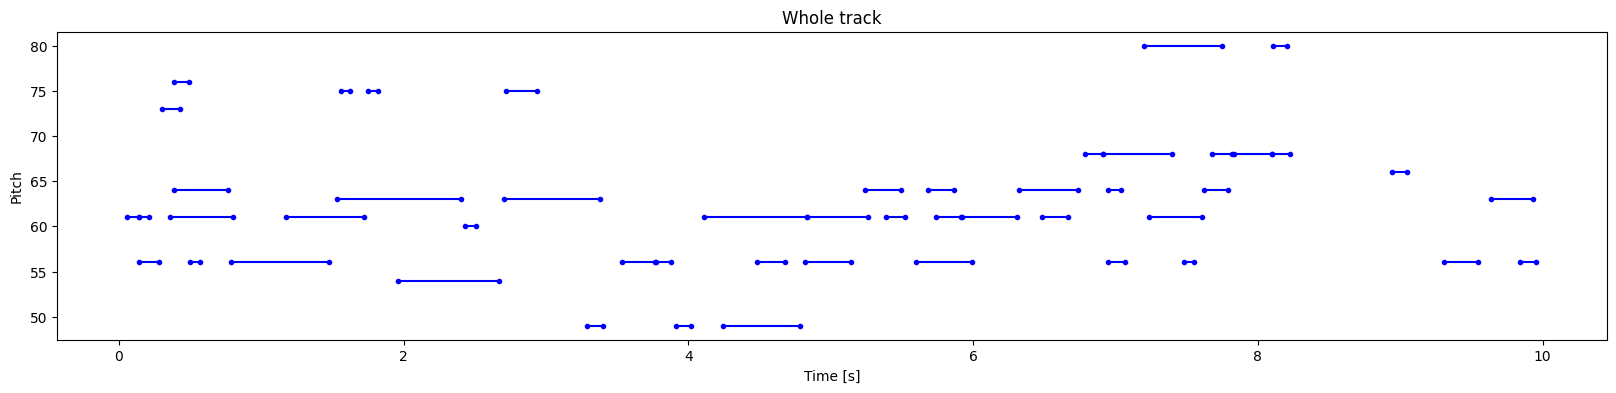

In [41]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [42]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

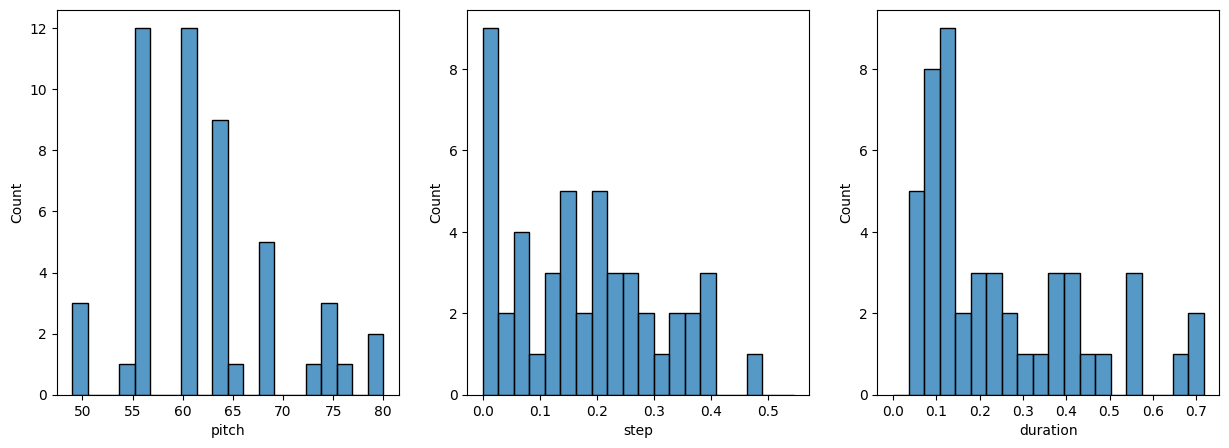

In [43]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [44]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [46]:
voice_file = 'voice_basic_pitch.mid'
example_pm = notes_to_midi(
    raw_notes, out_file=voice_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [51]:
display_audio(example_pm)

AttributeError: module 'fluidsynth' has no attribute 'Synth'

As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [60]:
num_files = 100
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [61]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 434043


Next, create a `tf.data.Dataset` from the parsed notes.

In [62]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [63]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [64]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [65]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [66]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[4.29687500e-01 0.00000000e+00 1.39062500e+00]
 [3.75000000e-01 1.30208333e-03 1.27083333e+00]
 [3.98437500e-01 0.00000000e+00 1.32812500e+00]
 [5.62500000e-01 6.40625000e-01 9.49218750e-01]
 [5.85937500e-01 9.20572917e-01 6.25000000e-02]
 [3.90625000e-01 8.85416667e-02 1.44270833e+00]
 [4.29687500e-01 2.60416667e-03 1.41015625e+00]
 [3.67187500e-01 3.90625000e-03 1.35677083e+00]
 [5.78125000e-01 3.90625000e-03 6.38020833e-02]
 [5.23437500e-01 5.97656250e-01 6.00260417e-01]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=77.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.006510416666666963>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.06510416666666607>}


Batch the examples, and configure the dataset for performance.

In [67]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [68]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [75]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [69]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses.
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [71]:
losses = model.evaluate(train_ds, return_dict=True)
losses

6781/6781 [==============================] - 71s 3ms/step - loss: 5.1790 - duration_loss: 0.1654 - pitch_loss: 4.8575 - step_loss: 0.1561


{'loss': 5.178973197937012,
 'duration_loss': 0.16537311673164368,
 'pitch_loss': 4.857506275177002,
 'step_loss': 0.1560831069946289}

One way balance this is to use the `loss_weights` argument to compile:

In [77]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [ ]:
model.evaluate(train_ds, return_dict=True)

214/214 [==============================] - 2s 3ms/step - loss: 1.1704 - duration_loss: 0.7957 - pitch_loss: 4.8611 - step_loss: 0.1316


{'loss': 1.1704301834106445,
 'duration_loss': 0.7957400679588318,
 'pitch_loss': 4.861086368560791,
 'step_loss': 0.13163532316684723}

Train the model.

In [73]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [90]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
6781/6781 [==============================] - 90s 6ms/step - loss: 0.3101 - duration_loss: 0.0952 - pitch_loss: 3.7422 - step_loss: 0.0277
Epoch 2/50
6781/6781 [==============================] - 36s 5ms/step - loss: 0.3065 - duration_loss: 0.0938 - pitch_loss: 3.7066 - step_loss: 0.0274
Epoch 3/50
6781/6781 [==============================] - 36s 5ms/step - loss: 0.3029 - duration_loss: 0.0920 - pitch_loss: 3.6808 - step_loss: 0.0269
Epoch 4/50
6781/6781 [==============================] - 37s 6ms/step - loss: 0.3013 - duration_loss: 0.0904 - pitch_loss: 3.6793 - step_loss: 0.0269
Epoch 5/50
6781/6781 [==============================] - 37s 5ms/step - loss: 0.2991 - duration_loss: 0.0889 - pitch_loss: 3.6693 - step_loss: 0.0267
Epoch 6/50
6781/6781 [==============================] - 36s 5ms/step - loss: 0.2971 - duration_loss: 0.0877 - pitch_loss: 3.6560 - step_loss: 0.0265
Epoch 7/50
6781/6781 [==============================] - 37s 5ms/step - loss: 0.2970 - duration_loss: 0.088

In [92]:
model.save("music_generator.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


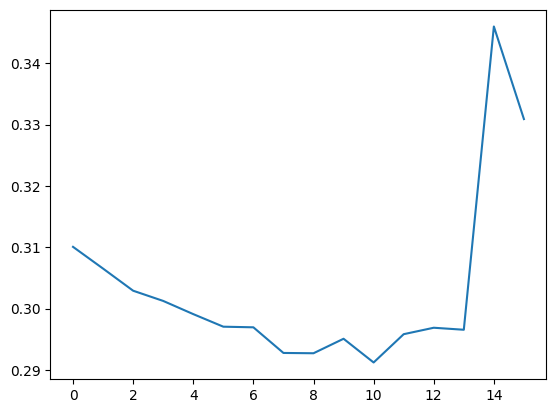

In [91]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [81]:
import numpy as np
import scipy.special
# ASSUMPTIONS:
# notes_sequence: numpy array of the sequence of notes so far
# notes: numpy array of all 128 notes
# -1 is sad, 1 is happy
def emotion_classifier(notes_sequence, current_emotion):

    notes_features = analyze_midi(notes_sequence)
    notes_features = np.array([value for value in notes_features.values()])

    kmeans_model.transform(notes_features)

    # Calculate distances from centroids
    distances = model.transform(notes_features.reshape(1, -1))
    softmax_distances = 1 - scipy.special.softmax(distances[0])
    emotion = 1 if current_emotion == 1 else 0

    # Find the index of the nearest cluster centroid
    emotion_score = softmax_distances[emotion]

    # Now you have the index of the nearest cluster centroid,
    # you can use it to classify the new point
    print("Predicted score for the new point:", emotion_score)

    return emotion_score


def pitch_logits_emotion_encloser(notes_sequence, pitches, pitch_logits, step, duration, label):
    # to tune hyperparameters
    alpha = 0.5
    beta = 0.5
    # everything happens after the prediction of the net
    # now we vectorize and do computations to output pitch logits influenced by the emotion
    vect_notes_sequence = np.array([notes_sequence] * 128)
    vect_step = np.array([step] * 128)
    vect_duration = np.array([duration] * 128)

    pitches = np.expand_dims(pitches, axis=1)
    vect_new_note = np.hstack((pitches, vect_step, vect_duration))
    vect_new_note = vect_new_note.reshape((128,1,3))
    vect_notes_sequence = np.hstack((vect_notes_sequence, vect_new_note))
    emotion_score = emotion_classifier(vect_notes_sequence, label)

    logits = alpha*pitch_logits + beta*emotion_score

    return logits

def step_emotion_encloser():
    #label is assumed 1 or -1 according to the emotion
    # to tune hyperparameters
    gamma_mean = 1.0
    gamma_std = 0.1
    gamma = abs(1-np.random.normal(gamma_mean, gamma_std, 1))
    return gamma


def duration_emotion_encloser():
    #label is assumed 1 or -1 according to the emotion
    # to tune hyperparameters
    delta_mean = 1.0
    delta_std = 0.1
    delta = abs(1-np.random.normal(delta_mean, delta_std, 1))
    return delta



## import kmeans model

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [79]:
def predict_next_note(
    pitches: np.ndarray,
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)


  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
  pitch_logits = pitch_logits_emotion_encloser(notes, pitches, pitch_logits, step, duration, label)
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [82]:
from keras.models import load_model

temperature = 2.0
num_predictions = 120

model = load_model('music_generator.h5', custom_objects={'mse_with_positive_pressure': mse_with_positive_pressure})
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)


# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))
generated_notes = []
prev_start = 0
pitches = np.arange(128)
pitches = np.expand_dims(pitches, axis=1)
gamma = step_emotion_encloser()
delta = duration_emotion_encloser()

for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(pitches,input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  step = float(step * (1- label * gamma))
  duration = float(duration * (1- label * delta))
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 439ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'start'

In [99]:
generated_notes.head(10) # sad(0.6, 2.0) happy(0.4, 1.5)

,pitch,step,duration,start,end


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

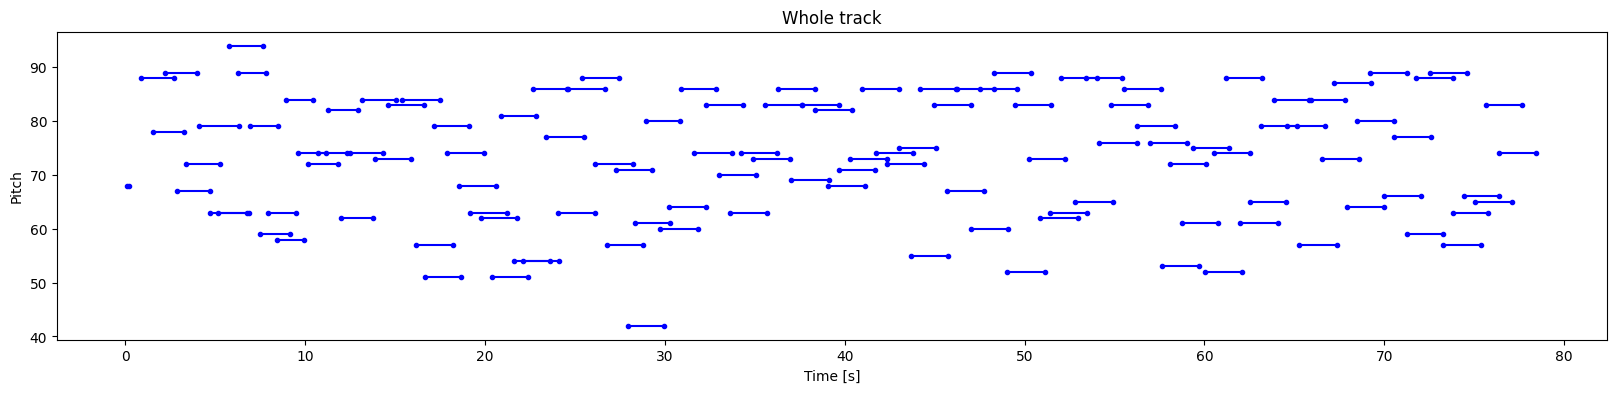

In [ ]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

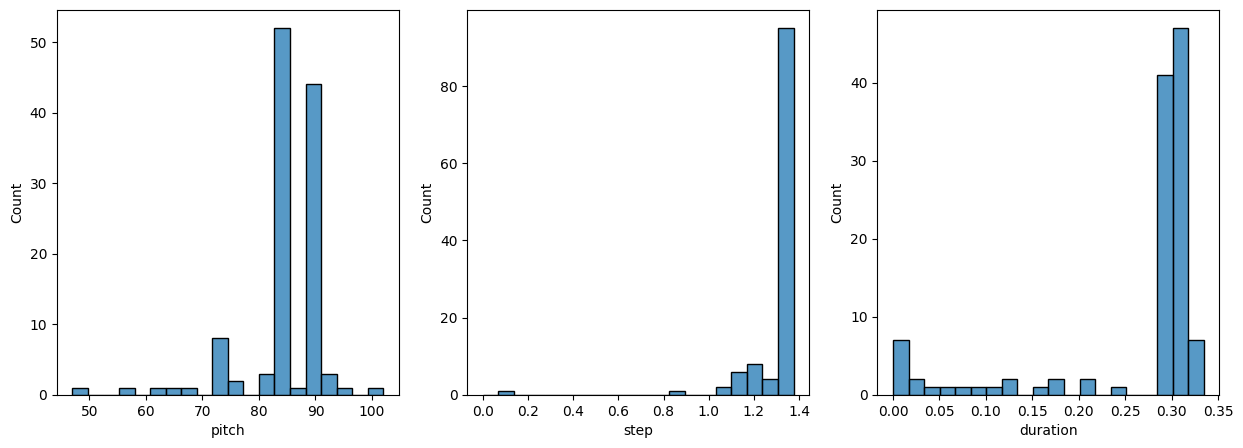

In [ ]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss.
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations.

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).